# Xilinx ML Developer Lab

## Introduction
Welcome to Xilinx's Virtual ML Suite Developer Lab. By completing this lab, you will gain valuable hands on experience in using the Xilinx ML Suite. This lab covers how to use Python APIs to deploy the included models, as well as how to compile and quantize custom models with the xfDNN Python tools.

Object Detection w/ YOLOv2 (Darknet -> Caffe)
This tutorial demonstrates the steps required to prepare and deploy a trained Darknet model for FPGA acceleration through the ML Suite. We will prepare a trained YOLO v2 model, and then run a single detection. 

For more information on the object detection model, Yolo, [please read more here][]. 

For more information on the ML Suite please visit [Xilinx.com/ml][] and [here][]

To use the Xilinx ML Suite for your own applications, please visit our [Github][]

Are you new to Jupyter Notebooks? Learn more here:  
[Basic Tutorial][]   
[Advanced Features][]    

[please read more here]: yolo-background.md

[Basic Tutorial]: https://github.com/Xilinx/PYNQ/blob/master/docs/source/jupyter_notebooks.ipynb
[Advanced Features]: https://github.com/Xilinx/PYNQ/blob/master/docs/source/jupyter_notebooks_advanced_features.ipynb
[Github]: https://github.com/Xilinx/ml-suite
[Xilinx.com/ml]: https://www.xilinx.com/ml
[here]: https://github.com/Xilinx/ml-suite/blob/master/docs/tutorials/ml-suite-overview.md


## Lab Overview 
The Lab is divided into 4 parts:   
**Part 1**: Darknet to Caffe conversion   
**Part 2**: Compile The Model   
**Part 3**: Quantize The Model  
**Part 4**: Deploy The Model  


**Ready? Lets begin!**  

## Part 1: Darknet to Caffe conversion

### 1. Import required packages and check environment

In [1]:
import os,sys,cv2,timeit
from __future__ import print_function

from matplotlib import pyplot as plt
%matplotlib inline

# Bring in Xilinx ML-Suite Compiler, Quantizer, PyXDNN
from xfdnn.tools.compile.bin.xfdnn_compiler_caffe import CaffeFrontend as xfdnnCompiler
from xfdnn.tools.quantize.quantize import CaffeFrontend as xfdnnQuantizer
#import xfdnn.rt.xdnn as pyxfdnn
#import xfdnn.rt.xdnn_io as pyxfdnn_io
import xfdnn.rt.xdnn as pyxfdnn
import xfdnn.rt.xdnn_io as pyxfdnn_io

# Bring in darknet2caffe functions
from darknet2caffe import *

# Bring in Non-Max Suppression 
import nms

# Bring in utility for drawing boxes
from yolo_utils import generate_colors, draw_boxes

# Ignore some warnings from the quantizer
import warnings
warnings.simplefilter("ignore", UserWarning)

print("Current working directory: %s" % os.getcwd())
print("Running on host: %s" % os.uname()[1])
print("Running w/ LD_LIBRARY_PATH: %s" %  os.environ["LD_LIBRARY_PATH"])
print("Running w/ XILINX_OPENCL: %s" %  os.environ["XILINX_OPENCL"])
print("Running w/ XCLBIN_PATH: %s" %  os.environ["XCLBIN_PATH"])
print("Running w/ PYTHONPATH: %s" %  os.environ["PYTHONPATH"])
print("Running w/ SDACCEL_INI_PATH: %s" %  os.environ["SDACCEL_INI_PATH"])
print("Running w/ LIBXDNN_PATH: %s" %  os.environ["LIBXDNN_PATH"])

!whoami 

# Make sure there is no error in this cell
# The xfDNN runtime depends upon the above environment variables

['/home/nimbix/ml-suite/notebooks/Xilinx-ML-Developer-Lab/pickle', '/home/nimbix/ml-suite/notebooks/Xilinx-ML-Developer-Lab/parallel', '/home/nimbix/ml-suite/notebooks/Xilinx-ML-Developer-Lab/bin', '/home/nimbix/ml-suite/notebooks/Xilinx-ML-Developer-Lab/version', '/home/nimbix/ml-suite/notebooks/Xilinx-ML-Developer-Lab/weights', '/home/nimbix/ml-suite/notebooks/Xilinx-ML-Developer-Lab/optimizations', '/home/nimbix/ml-suite/notebooks/Xilinx-ML-Developer-Lab/network', '/home/nimbix/ml-suite/notebooks/Xilinx-ML-Developer-Lab/memory', '/home/nimbix/ml-suite/notebooks/Xilinx-ML-Developer-Lab/graph', '/home/nimbix/ml-suite/notebooks/Xilinx-ML-Developer-Lab/codegeneration', '/home/nimbix/ml-suite/xfdnn/tools/compile/bin/../docs', '/home/nimbix/ml-suite/xfdnn/tools/compile/bin/../tests', '/home/nimbix/ml-suite/xfdnn/tools/compile/bin/../version', '/home/nimbix/ml-suite/xfdnn/tools/compile/bin/../examples', '/home/nimbix/ml-suite/xfdnn/tools/compile/bin/../network', '/home/nimbix/ml-suite/xfdn

### 2. Use a config dictionary to pass parameters and select an Image

First, we will setup and use a config dictionary to simplify handling of the arguments. For this example, we have a number of images to select from. Select one from the widget below. Image courtesy of openimages.


In [2]:
config = {}

config["platform"] = "alveo-u200"
    
# This is a widget that allows you to select an image from the calibration_directory.
# Run this and a dropdown will be presented with the selection of all the images from the calibration_directory.
# Select one and run the next block of code and it will grab the value.
#from ipywidgets import interact, interactive, interact_manual
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

calibration_path = "../../xfdnn/tools/quantize/calibration_directory/"
img_list = os.listdir(calibration_path)
img_list.reverse()
img = None

def setConfigImage(image):
    global img
    img = calibration_path+image
    
interact(setConfigImage,image=img_list,)
config["images"] = [img]


aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnaW1hZ2UnLCBvcHRpb25zPSgnMTYyNDc3MTY4NDNfYjQxOWU4YjExMV96LmpwZycsICcxNDkzMTQ4NjcyMF8zN2LigKY=


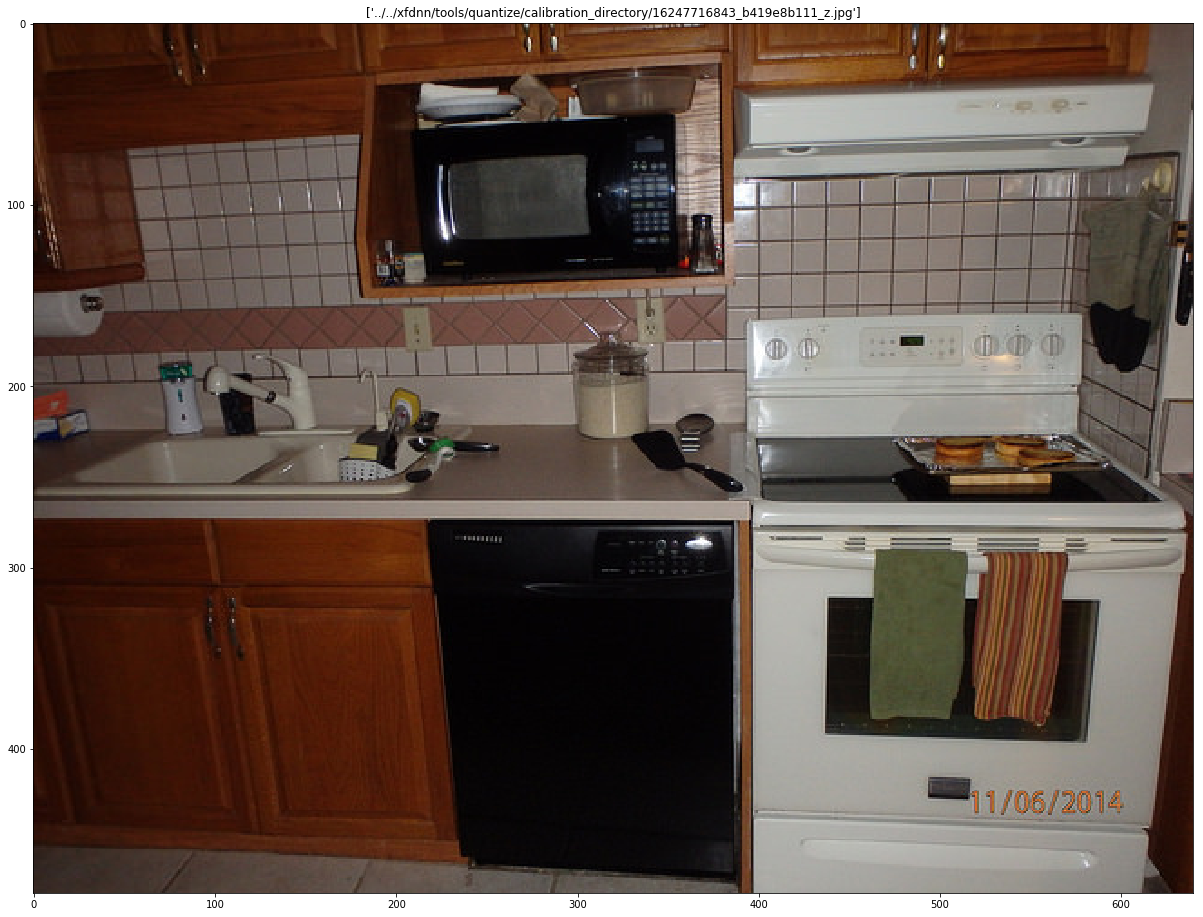

In [3]:
config["images"] = [img]

img = cv2.imread(config["images"][0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.rcParams['figure.figsize'] = [24.0,16.0]
plt.imshow(img)
plt.title(config["images"])
plt.show()

### 3. Run darknet2caffe script   

Here, we need to convert the model from darknet to caffe. The below cell will create a prototxt, and a caffemodel in the ./work directory. Such a translation will be necessary for any model defined in darknet.

In [4]:
# Run the darknet2caffe python script which will convert a yolov2 darknet model to a caffe model
# This script additionally will remove batchnorm layers, by merging the parameters
# This step is intentionally performed upstream of the compiler due to Darknet's non-conforming implementation of 
#   batch normalization

config["prototxt"] = "./work/yolov2.prototxt" 
config["caffemodel"] = "./work/yolov2.caffemodel"

darknet2caffe("../models/darknet/yolov2/fp32/yolo.xdnn.nobn.608.cfg",
              "../models/darknet/yolov2/fp32/yolo.xdnn.nobn.weights",
              config["prototxt"],
              config["caffemodel"])

block:OrderedDict([('type', 'route'), ('layers', '-9')])
block:OrderedDict([('type', 'route'), ('layers', '-1,-4')])
from_layer: ['-1', '-4']
prev_layer_id1: 28
prev_layer_id2: 25
layer_id: 29
concat_layer: OrderedDict([('name', 'layer29-concat'), ('type', 'Concat'), ('bottom', ['layer28-maxpool', 'layer25-conv']), ('top', 'layer29-concat')])
net
convolutional
maxpool
convolutional
maxpool
convolutional
convolutional
convolutional
maxpool
convolutional
convolutional
convolutional
maxpool
convolutional
convolutional
convolutional
convolutional
convolutional
maxpool
convolutional
convolutional
convolutional
convolutional
convolutional
convolutional
convolutional
route
convolutional
maxpool
route
convolutional
convolutional
save prototxt to ./work/yolov2.prototxt
save caffemodel to ./work/yolov2.caffemodel


## Part 2: Compile The Model

In this part, you will learn what steps are required to prepare and compile a network and model. Before being able to deploy networks/models to Xilinx FPGAs you will need to compile them.  

This step is more than just converting the framework graph representation to one Xilinx can execute. The xfDNN Compiler is a high performance optimizer for Machine Learning inference. Some of the techniques it performs are fusing and merging layers, optimizing memory usage and pre-scheduling complete network deployment. These techniques increase inference rates and lower inference latency. 

Using the xfDNN Compiler is an offline process, which only needs to be performed once per network. As you will see, the process is simple and quick. 


### 4. Define an xfdnnCompiler instance and pass it arguments    
To simplify handling of arguments, we continue to use a config dictionary. Take a look at the dictionary entries below. 

The arguments that need to be passed are: 
- `prototxt` - Caffe representation of the network
- `caffemodel` - Pre-trained Model for the network 
- `outmodel` - Filename for saving the prototxt and caffemodel of the optimized network
- `netcfg` - Filename to save micro-instruction produced by the compiler needed to deploy
- `memory` - Parameter to set the on-chip memory for the target xDNN overlay. This example will target an overlay with 5 MB of cache. 
- `dsp` - Parameter to set the size of the target xDNN overlay. This example uses an overlay of size 32x56 DSPs. 

**Please Note:**  
Memory, and DSP are critical arguments that correspond to the hardware accelerator you plan to load onto the FPGA.  
To learn more about the available overlays and these parameters, please visit the [Overlay Selector Guide][]. 
  

The xfDNN Compiler interfaces with Caffe to read a network graph, and generates a sequence of instructions for the xfDNN Deploy APIs to execute on the FPGA.  

During this process the xfDNN Compiler performs computational graph traversal, node merging and optimization, memory allocation and optimization and, finally, micro-instruction generation.

[Overlay Selector Guide]: https://github.com/Xilinx/ml-suite/blob/master/overlaybins/README.md

In [5]:
# Compiler Arguments
#config["prototxt"] = "./work/yolov2.prototxt" 
#config["caffemodel"] = "./work/yolov2.caffemodel"
config["outmodel"] = "../work/optimized_model" # String for naming optimized prototxt, caffemodel
config["netcfg"] = "../work/fpga.cmds" # Compiler will generate FPGA instructions
config["memory"] = 5 # Available on-chip SRAM
config["dsp"] = 56 # Width of Systolic Array

compiler = xfdnnCompiler(
    networkfile=config["prototxt"],       # Prototxt filename: input file
    weights=config["caffemodel"],         # Floating Point Weights: input file
    anew=config["outmodel"],              # String for intermediate prototxt/caffemodel
    generatefile=config["netcfg"],        # Script filename: output file
    memory=config["memory"],              # Available on chip SRAM within xclbin
    dsp=config["dsp"]                     # Rows in DSP systolic array within xclbin
)

# Invoke compiler
try:
    compiler.compile()

    # The compiler extracts the floating point weights from the .caffemodel. 
    # This weights dir will be stored in the work dir with the appendex '_data'. 
    # The compiler will name it after the caffemodel, and append _data
    config["datadir"] = "../work/" + config["caffemodel"].split("/")[-1]+"_data"
        
    if os.path.exists(config["datadir"]) and os.path.exists(config["netcfg"]+".json"):
        print("Compiler successfully generated JSON and the data directory: %s" % config["datadir"])
    else:
        print("Compiler failed to generate the JSON or data directory: %s" % config["datadir"])
        raise
        
    print("**********\nCompilation Successful!\n")
    
    import json
    data = json.loads(open(config["netcfg"]+".json").read())
    print("Network Operations Count: %d"%data['ops'])
    print("DDR Transfers (bytes): %d"%data['moveops']) 
    
except Exception as e:
    print("Failed to complete compilation:",e)


Namespace(anew='../work/optimized_model', approximate=False, banditpre=None, barrier=False, bridges=None, bytesperpixels=2, concatstrategy=None, conv_1x1_s2=False, cpulayermustgo=False, darius=None, ddr=256, dedicateddsp=None, deephifilename=None, dsp=56, forceweights=None, fromtensorflow=False, generatefile='../work/fpga.cmds', godreplication=None, lasttensorbyname=None, loadpickle=None, manasadebugmode=False, memory=5, networkfile='./work/yolov2.prototxt', nodynamicscaling=False, noreplication=False, parallelism=False, parallelismstrategy="['bottom', 'tops']", parallelread=None, phase='TEST', pipelineconvmaxpool=False, pngfile=None, poolingaround=False, rankdir='BT', savepickle=None, schedulefile=None, strategy='all', verbose=False, versionjson=None, weights='./work/yolov2.caffemodel')
Network: ./work/yolov2.prototxt
GenerateCode: ../work/fpga.cmds
Weights: ./work/yolov2.caffemodel
PngFile: None
ConcatStrategy: None
Strategy: all
ScheduleFile: None
DDR: 256
DSP: 56
DSP V2
Verbose: Fa

Done schedule 31 STEPS
**************************************************
* GENERATING OUTPUT REPORTS
**************************************************
schedule_and_parallelism
Minimum Memory 3 ['layer3-conv'] 34865152.0
layer2-maxpool_blob M[27394048,34865152] Z=7471104 F=[3] B=[2] E=[1] S=['layer'] [] L=1 T=SizeType(batches=1, channels=32, height=304, width=304)
layer3-conv_blob M[0,14942208] Z=14942208 F=[4] B=[3] E=[1] S=['layer'] [] L=1 T=SizeType(batches=1, channels=64, height=304, width=304)
**************************************************
* GENERATING OUTPUT FILES
**************************************************
XDNN Command file: ../work/fpga.cmds
XDNN JSON Report file: ../work/fpga.cmds.json
../work
Path to generatefile exists...
***** Inst JSON
<class 'argparse.Namespace'>
OUTPUT REPORT:
Unsupported Layers: 0
***** Inst JSON Done
***** Inst FILE
***** Inst FILE OUT
***** Inst COLLECT
***** COLLECT CODES 177
# template XNAvgPool id XNOp name kernel_w kernel_h  strides_w 

* fwbqb_bias_13
* fwbqb_bias_10
* fwbqb_13
* wbq_size_9
* wbq_size_15
* fwbqb_bias_20
* fwbqb_11
* wbq_size_21
* wbq_size_5
* fwbqb_bias_1
* wbq_size_10
* fwbqb_15
* fwbqb_2
* wbq_size_20
* fwbqb_1
* fwbqb_bias_21
* fwbqb_bias_4
* fwbqb_14
* fwbqb_5
* fwbqb_bias_6
* wbq_size_6
* fwbqb_4
* wbq_size_8
* fwbqb_17
* fwbqb_bias_11
* fwbqb_bias_9
* wbq_size_2
* fwbqb_3
* fwbqb_bias_15
* wbq_size_13
* wbq_size_11
* fwbqb_8
* fwbqb_bias_8
* wbq_size_1
* wbq_size_12
* fwbqb_19
* wbq_size_3
* fwbqb_12
* wbq_size_0
* fwbqb_bias_12
* fwbqb_bias_5
**************************************************
Writing weights to directory: ../work/yolov2.caffemodel_data
Processing schedule step 1/31
	Layer: data
Processing schedule step 2/31
	Layer: layer1-conv
Processing schedule step 3/31
	Layer: layer2-maxpool
Processing schedule step 4/31
	Layer: layer3-conv
Processing schedule step 5/31
	Layer: layer4-maxpool
Processing schedule step 6/31
	Layer: layer5-conv
Processing schedule step 7/31
	Layer: layer6-con

## Part 3: Quantize The Model

In this part of the lab, we will look at quantizing 32-bit floating point models to Int16 or Int8 inpreparation for deployment. Deploying Int16/8 models dramatically improves inference deployment and lowers latency. While floating point precision is useful in model training, it is more energy efficient, as well as, lower latency to deploy models in lower precison.

The xfDNN Quantizer performs a technique of quantization known as recalibration. This technique does not require full retraining of the model, and can be accomplished in a matter of seconds, as you will see below. It also allows you to maintain the accuracy of the high precision model.

Quantization of the model does not alter the orginal high precision model, rather, it calculates the dynamic range of the model and produces scaling parameters recorded in a json file, which will be used by the xDNN overlay during execution of the network/model. Quantization of the model is an offline process that only needs to be performed once per model. The quantizer produces an optimal target quantization from a given network (prototxt and caffemodel) and calibration set (unlabeled input images) without requiring hours of retraining or a labeled dataset.  


### 5. Create Quantizer Instance and pass arguments

To simplify handling of arguments, a config dictionary is used. Take a look at the dictionary below.

The arguments that need to be passed are:
- `deploy_model` - Filename generated by the compiler for the optimized prototxt and caffemodel.
- `quantizecfg` - Output JSON filename of quantization scaling parameters. 
- `bitwidths` - Desired precision from quantizer. This is to set the precision for [image data, weight bitwidth, conv output]. All three values need to be set to the same setting. The valid options are `16` for Int16 and `8` for Int8.  
- `in_shape` - Sets the desired input image size of the first layer. Images will be resized to these demensions and must match the network data/placeholder layer.
- `transpose` - Images start as H,W,C (H=0,W=1,C=2) transpose swaps to C,H,W (2,0,1) for typical networks.
- `channel_swap` - Depending on network training and image read, can swap from RGB (R=0,G=1,B=2) to BGR (2,1,0).
- `raw_scale` - Depending on network training, scale pixel values before mean subtraction.
- `img_mean` - Depending on network training, subtract image mean if available.
- `input_scale` - Depending on network training, scale after subtracting mean.
- `calibration_size` - Number of images the quantizer will use to calculate the dynamic range. 
- `calibration_directory` - Location of dir of images used for the calibration process. 

Below is an example with all the parameters filled in. `channel_swap` `raw_scale` `img_mean` `input_scale` are image preprocessing arguments specific to a given model.

**Note:** This may take a couple of minutes to complete. 

In [6]:
# Use a config dictionary to pass parameters to the compiler
# Quantizer Arguments
#config["outmodel"] = Defined in Step 4 # String for naming intermediate prototxt, caffemodel
config["quantizecfg"] = "../work/quantization_params.json" # Quantizer will generate quantization params
config["bitwidths"] = [16,16,16] # Supported quantization precision
config["in_shape"] = [3,608,608] # Images will be resized to this shape -> Needs to match prototxt
config["transpose"] = [2,0,1] # (H,W,C)->(C,H,W) transpose argument to quantizer
config["channel_swap"] = [2,1,0] # (R,G,B)->(B,G,R) Channel Swap argument to quantizer
config["raw_scale"] = 1.0 # Yolo effectively divides by 255 (Quantizer will represent image as 0 <-> 1 which is equiv)
config["img_mean"] = [0.0, 0.0, 0.0] # Mean of the training set used for mean subtraction (Not performed for yolo)
config["input_scale"] = 1.0 # Input multiplier, Images are scaled by this factor after mean subtraction
config["calibration_size"] = 15 # Number of calibration images quantizer will use
config["calibration_directory"] = "../../xfdnn/tools/quantize/calibration_directory" # Directory of images

quantizer = xfdnnQuantizer(
    deploy_model=config["outmodel"]+".prototxt",        # Model filename: input file
    weights=config["outmodel"]+".caffemodel",           # Floating Point weights
    output_json=config["quantizecfg"],                    # Quantization JSON output filename
    bitwidths=config["bitwidths"],                        # Fixed Point precision: 8,8,8 or 16,16,16
    dims=config["in_shape"],                              # Image dimensions [C,H,W]
    transpose=config["transpose"],                        # Transpose argument to caffe transformer
    channel_swap=config["channel_swap"],                  # Channel swap argument to caffe transfomer
    raw_scale=config["raw_scale"],                        # Raw scale argument to caffe transformer
    mean_value=config["img_mean"],                        # Image mean per channel to caffe transformer
    input_scale=config["input_scale"],                    # Input scale argument to caffe transformer
    calibration_size=config["calibration_size"],          # Number of calibration images to use
    calibration_directory=config["calibration_directory"] # Directory containing calbration images
)

# Invoke quantizer
try:
    quantizer.quantize()

    import json
    data = json.loads(open(config["quantizecfg"]).read())
    print("**********\nSuccessfully produced quantization JSON file for %d layers.\n"%len(data['network']))
except Exception as e:
    print("Failed to quantize:",e)

('Mean :', array([0., 0., 0.]))
Adding ../../xfdnn/tools/quantize/calibration_directory/36085792773_b9a3d115a3_z.jpg to calibration batch.
Adding ../../xfdnn/tools/quantize/calibration_directory/5904386289_924b24d75d_z.jpg to calibration batch.
Adding ../../xfdnn/tools/quantize/calibration_directory/15439525724_97d7cc2c81_z.jpg to calibration batch.
Adding ../../xfdnn/tools/quantize/calibration_directory/7291910830_86a8ebb15d_z.jpg to calibration batch.
Adding ../../xfdnn/tools/quantize/calibration_directory/3272651417_27976a64b3_z.jpg to calibration batch.
Adding ../../xfdnn/tools/quantize/calibration_directory/AdrianStoica_Rory_discdog.jpg to calibration batch.
Adding ../../xfdnn/tools/quantize/calibration_directory/8289365270_82b20ef781_z.jpg to calibration batch.
Adding ../../xfdnn/tools/quantize/calibration_directory/4788821373_441cd29c9f_z.jpg to calibration batch.
Adding ../../xfdnn/tools/quantize/calibration_directory/13923040300_b4c8521b4d_z.jpg to calibration batch.
Adding ..

('Min: ', 0, ', Max: ', 25.913027)
('n: ', 32768, ', len(bin_edges): ', 6662)
('Mean : th_layer_out: ', 25.913026809692383, ', sf_layer_out: ', 0.0007908269542433663)
bw_layer_out:  16
th_layer_out:  25.913026809692383
--------------------------------------------------------------------------------
Processing layer 13 of 54
Layer Name:layer8-maxpool Type:Pooling
Inputs: ['layer7-conv'], Outputs: ['layer8-maxpool']
bw_layer_in:  16
th_layer_in:  25.913026809692383
bw_layer_out:  16
th_layer_out:  25.913026809692383
--------------------------------------------------------------------------------
Processing layer 14 of 54
Layer Name:layer9-conv Type:Convolution
Inputs: ['layer8-maxpool'], Outputs: ['layer9-conv']
Quantizing conv input layer ... layer9-conv
Threshold in shape= ()
Quantizing conv weights for layer layer9-conv...
Threshold params shape= (256,)
('Min: ', 0, ', Max: ', 15.807889)
('n: ', 32768, ', len(bin_edges): ', 4711)
('Mean : th_layer_out: ', 15.807888984680176, ', sf_lay

('Min: ', 0, ', Max: ', 18.41201)
('n: ', 32768, ', len(bin_edges): ', 2356)
('Mean : th_layer_out: ', 18.412010192871094, ', sf_layer_out: ', 0.0005619071075432933)
Threshold out shape= ()
('Min: ', 0, ', Max: ', 18.41201)
('n: ', 32768, ', len(bin_edges): ', 2356)
('Mean : th_layer_out: ', 18.412010192871094, ', sf_layer_out: ', 0.0005619071075432933)
bw_layer_in:  16
th_layer_in:  10.770570755004883
bw_layer_out:  16
th_layer_out:  18.412010192871094
--------------------------------------------------------------------------------
Processing layer 28 of 54
Layer Name:layer16-conv_relu Type:ReLU
Inputs: ['layer16-conv'], Outputs: ['layer16-conv']
('Min: ', 0, ', Max: ', 18.41201)
('n: ', 32768, ', len(bin_edges): ', 2356)
('Mean : th_layer_out: ', 18.412010192871094, ', sf_layer_out: ', 0.0005619071075432933)
bw_layer_out:  16
th_layer_out:  18.412010192871094
--------------------------------------------------------------------------------
Processing layer 29 of 54
Layer Name:layer17-

bw_layer_in:  16
th_layer_in:  28.41346549987793
bw_layer_out:  16
th_layer_out:  81.79021453857422
--------------------------------------------------------------------------------
Processing layer 42 of 54
Layer Name:layer23-conv_relu Type:ReLU
Inputs: ['layer23-conv'], Outputs: ['layer23-conv']
('Min: ', 0, ', Max: ', 69.987366)
('n: ', 32768, ', len(bin_edges): ', 2356)
('Mean : th_layer_out: ', 69.98736572265625, ', sf_layer_out: ', 0.002135910084006966)
bw_layer_out:  16
th_layer_out:  69.98736572265625
--------------------------------------------------------------------------------
Processing layer 43 of 54
Layer Name:layer24-conv Type:Convolution
Inputs: ['layer23-conv'], Outputs: ['layer24-conv']
Quantizing conv input layer ... layer24-conv
Threshold in shape= ()
Quantizing conv weights for layer layer24-conv...
Threshold params shape= (1024,)
('Min: ', 0, ', Max: ', 15.215668)
('n: ', 32768, ', len(bin_edges): ', 2356)
('Mean : th_layer_out: ', 15.215667724609375, ', sf_layer_

## Part 4: Deploy The Model


Next, we need to utilize the xfDNN APIs to deploy our network to the FPGA. We will walk through the deployment APIs, step by step: 
1. Open a handle for FPGA communication
2. Load weights, biases, and quantization parameters to the FPGA DDR
3. Allocate storage for FPGA inputs (such as images to process)
4. Allocate storage for FPGA outputs (the activation of the final layer run on the FPGA)
5. Execute the network
6. Run region layer on the CPU
7. Run non-max suppression on the CPU
8. Print the result 
9. When you are done, close the handle to the FPGA

First, we will create the handle to communicate with the FPGA and choose which FPGA overlay to run the inference on. For this lab, we will use the `xdnn_v2_32x56_2pe_16b_6mb_bank21` overlay. You can learn about other overlay options in the ML Suite Tutorials [Overlay Selector Guide][].  

[Overlay Selector Guide]: https://github.com/Xilinx/ml-suite/blob/master/overlaybins/README.md
        
### 6. Open a handle for FPGA communication

In [7]:
# Create a handle with which to communicate to the FPGA
# The actual handle is managed by xdnn
config["xclbin"] = "../../overlaybins/" + config["platform"] + "/overlay_3.xclbin" # Chosen Hardware Overlay
## NOTE: If you change the xclbin, we likely need to change some arguments provided to the compiler
## Specifically, the DSP array width, and the memory arguments

ret, handles = pyxfdnn.createHandle(config['xclbin'])
if ret:                                                             
    print("ERROR: Unable to create handle to FPGA")
else:
    print("INFO: Successfully created handle to FPGA")
    
# If this step fails, most likely the FPGA is locked by another user, or there is some setup problem with the hardware

INFO: Successfully created handle to FPGA


### 7. Apply quantization scaling and transfer model weights to the FPGA

In [8]:
# Quantize, and transfer the weights to FPGA DDR

config["scaleA"] = 10000 # Global scaler for weights (Must be defined)
config["scaleB"] = 30 # Global scaler for bias (Must be defined)
config["PE"] = 0 # Run on Processing Element 0 - Different xclbins have a different number of Elements
config["batch_sz"] = 1 # We will load 1 image at a time from disk
config["in_shape"] = (3,608,608) # We will resize images to 608x608

#(weightsBlob, fcWeight, fcBias ) = pyxfdnn_io.loadWeights(config)
fpgaRT = pyxfdnn.XDNNFPGAOp(handles,config)
(fcWeight, fcBias) = pyxfdnn_io.loadFCWeightsBias(config)

Loading weights/bias/quant_params to FPGA...
No FC layers found in ../work/yolov2.caffemodel_data


### 8. Allocate space in host memory for inputs, load images from disk, and prepare images

In [9]:
# Allocate space in host memory for inputs, Load images from disk
batch_array = np.empty(((config['batch_sz'],) + config['in_shape']), dtype=np.float32, order='C')
img_paths = pyxfdnn_io.getFilePaths(config['images'])

shapes = []
for i in xrange(0, len(img_paths), config['batch_sz']):
    pl = []
    for j, p in enumerate(img_paths[i:i + config['batch_sz']]):
        batch_array[j, ...], s = pyxfdnn_io.loadYoloImageBlobFromFile(p, config['in_shape'][2], config['in_shape'][1])
        pl.append(p)
        shapes.append(s)

### 9. Allocate space in host memory for outputs

In [10]:
# Allocate space in host memory for outputs

# The output of a yolo network is more complex than most networks.

# In YOLOv2 the input image is square, and it is divided into grid cells of 32 pixels each.
# For example, a 608x608 image would yield a volume with HxW = 19x19. Where 19 = 608/32
#              a 224x224 image would yield a volume with HxW = 7x7
out_h = out_w = config["in_shape"][1] / 32

# For each grid cell in the input image, YOLOv2 considers the possibility of 5 objects being present (Anchor Boxes)
#   For each anchor box, YOLOv2 computes
#   - The probability that there is an object in the anchor box - 1 element
#   - The x,y,w,h coordinates of a bounding box (centroid and width height of box) - 4 elements
#   - The class probabilities (Number of classes depends on dataset) We use MS COCO which has 80 classes - 80 elements
anchor_boxes = 5
objectness = 1
coordinates = 4
classes = 80
out_c = objectness+coordinates+classes

# Number of elements in the activation of the last layer ran on the FPGA
config["fpgaoutsz"] = anchor_boxes*out_c*out_h*out_w 

fpgaOutput = np.empty ((config['batch_sz'], config['fpgaoutsz'],), dtype=np.float32, order='C') # Space for fpga output

print ("YOLOv2 will produce an output volume of shape (%dx%dx%dx%d) consisting of %d elements" \
           %(anchor_boxes,out_c,out_h,out_w,config["fpgaoutsz"]))


YOLOv2 will produce an output volume of shape (5x85x19x19) consisting of 153425 elements


### 10. Write optimized micro-code to the xDNN Processing Engine on the FPGA. Execute the network

In [11]:
# Write FPGA Instructions to FPGA and Execute the network!
startTime = timeit.default_timer()
fpgaRT.execute(batch_array, fpgaOutput)
elapsedTime = timeit.default_timer() - startTime
print("Time to load microcode and execute %d ms" % (elapsedTime*1000))
    
# Note that the time printed here is the time to transfer microcode to the FPGA + the time to execute
# Iterative calls to this cell will produce the real latency number

Time to load microcode and execute 95 ms


### 11. Execute the YOLOv2 region layer on the CPU
The region layer requires the sigmoid function to be applied to the X/Y coordinates of each prediction, and the box confidence. It also requires the softmax to be computed across all class scores in each anchor box. Here we use numpy to acheive this.

In [12]:
# Functions Required for implementing YOLOv2 region layer
# Implemented using numpy in a numerically stable manner
def sigmoid(x):
    pos_mask = (x >= 0)
    neg_mask = (x < 0)
    z = np.zeros_like(x)
    z[pos_mask] = np.exp(-x[pos_mask])
    z[neg_mask] = np.exp(x[neg_mask])
    top = np.ones_like(x)
    top[neg_mask] = z[neg_mask]
    return top / (1 + z)

def softmax(x):
    e_x = np.exp(x-np.max(x))
    return (e_x)/(e_x.sum(axis=0,keepdims=True))

startTime = timeit.default_timer()
# Reshape the fpgaOutputs into a 4D volume
fpgaOutput = fpgaOutput.reshape(anchor_boxes,out_c,out_h,out_w)

# Apply sigmoid to 1st, 2nd, 4th channel for all anchor boxes
fpgaOutput[:,0:2,:,:] = sigmoid(fpgaOutput[:,0:2,:,:]) # (X,Y) Predictions
fpgaOutput[:,4,:,:]   = sigmoid(fpgaOutput[:,4,:,:])   # Objectness / Box Confidence

# Apply softmax on the class scores foreach anchor box
for box in range(anchor_boxes):
    fpgaOutput[box,5:,:,:]  = softmax(fpgaOutput[box,5:,:,:])
    
elapsedTime = timeit.default_timer() - startTime
print(elapsedTime*1000, "ms")

3.44204902649 ms


### 12. Execute NMS on the CPU
Non-Max Suppression is the algorithim used to filter out redundant predictions. For instance, yolo could have produced multiple bounding boxes for the same object. Additionally, predictions made with low confidence are thrown out.
We have encapsulated some C code for implementing NMS in a python wrapper.

In [13]:
# Perform Non-Max Suppression
# Non-Max Suppression filters out detections with a score lesser than 0.24
# Additionally if there are two predections with an overlap > 30%, the prediction with the lower score will be filtered
scorethresh = 0.24
iouthresh = 0.3
bboxes = nms.do_baseline_nms(fpgaOutput.flat,
                             shapes[0][1],
                             shapes[0][0],
                             config['in_shape'][2],
                             config['in_shape'][1],
                             out_w,
                             out_h,
                             anchor_boxes,
                             classes,
                             scorethresh,
                             iouthresh)

### 13. Print out results
After NMS all operations are complete. Now we must print the results, and we can draw the detections on the original image for reference.

Obj 0: sink
	 score = 0.349112
	 (xlo,ylo) = (23,260)
	 (xhi,yhi) = (156,233)
Obj 1: oven
	 score = 0.497165
	 (xlo,ylo) = (225,465)
	 (xhi,yhi) = (396,239)
Obj 2: microwave
	 score = 0.865883
	 (xlo,ylo) = (206,148)
	 (xhi,yhi) = (368,34)
Obj 3: oven
	 score = 0.549200
	 (xlo,ylo) = (388,479)
	 (xhi,yhi) = (636,160)
oimage = 16247716843_b419e8b111_z.jpg
Saving new image with bounding boxes drawn as ../work/16247716843_b419e8b111_z.jpg


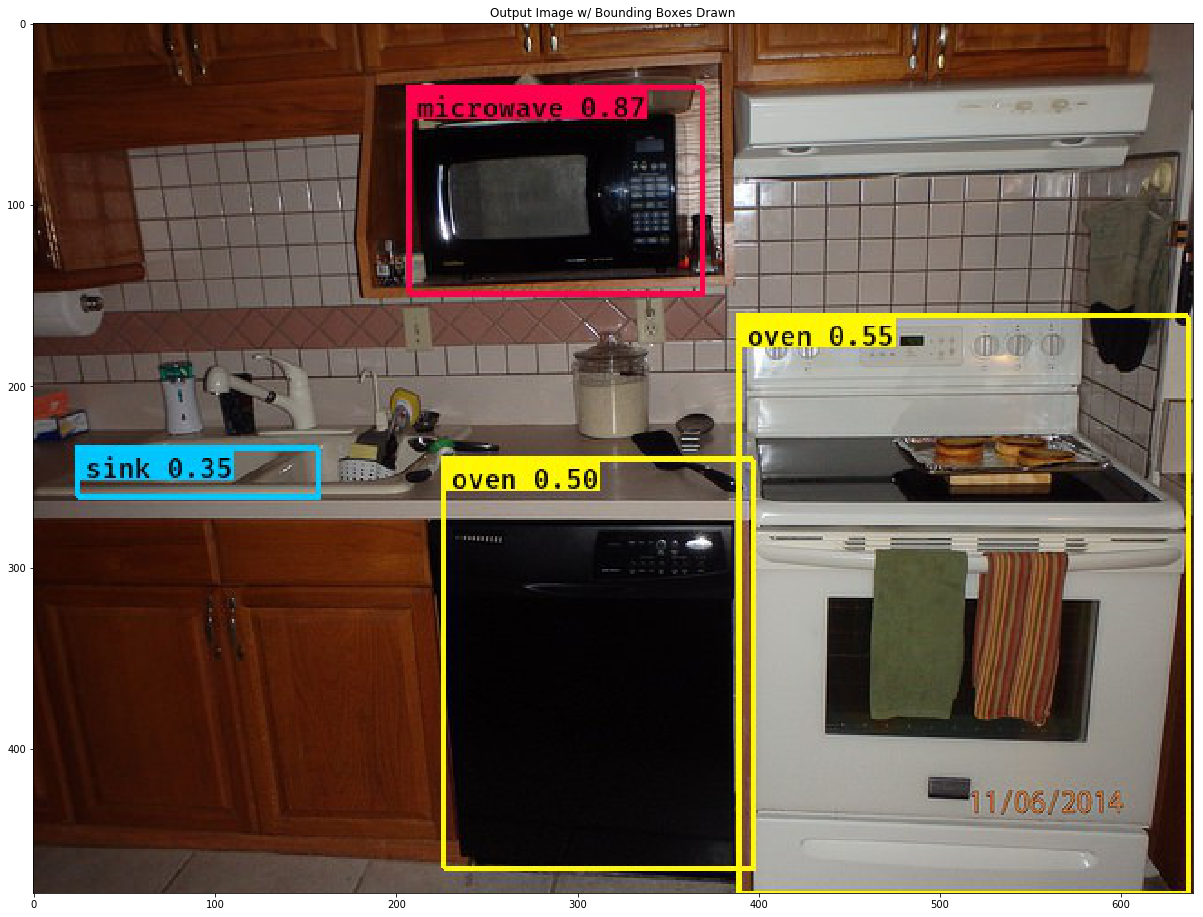

In [14]:
# Create a list of class labels given a file containing the coco dataset classes
with open("../../apps/yolo/coco.names") as f:      
    namez = f.readlines()      
    names = [x.strip() for x in namez]
    
# Lets print the detections our model made
for j in range(len(bboxes)):
    print("Obj %d: %s" % (j, names[bboxes[j]['classid']]))
    print("\t score = %f" % (bboxes[j]['prob']))
    print("\t (xlo,ylo) = (%d,%d)" % (bboxes[j]['ll']['x'], bboxes[j]['ll']['y']))
    print("\t (xhi,yhi) = (%d,%d)" % (bboxes[j]['ur']['x'], bboxes[j]['ur']['y']))
    
# Given the detection results above, lets draw our findings on the original image, and display it
colors = generate_colors(classes)
draw_boxes(config["images"][0],bboxes,names,colors,"../work","../../apps/yolo/font",False)
outimage = "../work/" + config["images"][0].split("/")[-1]
img = cv2.imread(outimage)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.rcParams['figure.figsize'] = [24.0,16.0]
plt.imshow(img)
plt.title("Output Image w/ Bounding Boxes Drawn")
plt.show()

### 14. Close the handle

In [15]:
pyxfdnn.closeHandle()

# You're Done! 

Now that you have made it this far, try selecting another image from the widget in Step 1 and click **Kernel** from the menu, and select **Restart & Run All** to see if you can classify the flower! 